In [1]:
import sys
sys.path.append('/home/chasenberg/repos/')
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os, sys, time, random
import ROOT 
from ROOT import TTree, TFile

# from root_numpy import root2array, rec2array, array2root

import pandas as pd
import numpy as np
import scipy 
import root_pandas as rp
import root_numpy as ry 

import pandas.core.common as com
from pandas.core.index import Index
from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix

from tqdm import tqdm_notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

sys.path.append('/home/chasenberg/repos/')
sys.path.append('/home/chasenberg/repos/dopy')
from dopy import * 
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations
from dopy.dolearn.sklearn_utils import plot_feature_importances, plot_classifier_output, classify_unseen_data
#from dopy.sklearn_utils import plot_bdt_vars
from dopy.doplot.plotting import Plotter, Plot
from dopy.doanalysis.df_utils import add_min_max, add_eta 

In [3]:
#mc_dir = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/wrong_pv'
#sig_file = 'Bd2JpsimumuKS_mc_2015_2016_selected.root'
mc_dir = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/'
sig_file = 'Bd2JpsiKS_selected.root'
signal_dir = os.path.join(mc_dir, sig_file)

In [51]:
tree_name = 'Bd2JpsiKS'

branch_names_mc = ['B0_FitPVConst_MinIPCHI2anyPV_flat',            
                   'pv_z_pull',
                  'piplus_TRACK_Type',
                  'B0_TAU',
                  'idxPV']

#pre_cut = 'catBkg==0&&obsMass>5200&&obsMass<5450&&obsTime>-17&&obsTime<18.0&&B0_FitDaughtersPVConst_status_flat==0&&B0_FitDaughtersConst_status_flat==0&&B0_FitPVConst_status_flat==0&&catTriggerSetNoIP==1&muplus_MINIPCHI2>0&muminus_MINIPCHI2>0&piplus_MINIPCHI2>0&piminus_MINIPCHI2>0&'
pre_cut ='idxPV==0&'


In [52]:
df_ll = rp.read_root(signal_dir, tree_name, columns=branch_names_mc, where=pre_cut+'piplus_TRACK_Type==3',flatten=False)
df_ll = df_ll.replace([np.inf, -np.inf], np.nan)
df_ll = df_ll.dropna()
df_n_events_ll = len(df_ll)
print('Number of events (LL): ' + str(df_n_events_ll))

df_dd = rp.read_root(signal_dir, tree_name, columns=branch_names_mc, where=pre_cut+'piplus_TRACK_Type==5',flatten=False)
df_dd = df_dd.replace([np.inf, -np.inf], np.nan)
df_dd = df_dd.dropna()
df_n_events_dd = len(df_dd)
print('Number of events (DD): ' + str(df_n_events_dd))

Number of events (LL): 146639
Number of events (DD): 383966


In [53]:
df_list = [df_dd, df_ll]
df_names = ['MC (DD)', 'MC (LL)']

#math.sqrt(df_dd['pv_z_pull'].var())

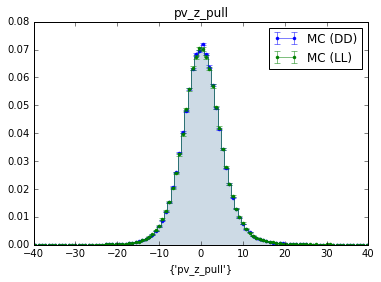

In [54]:
plot_vars = ['pv_z_pull']
plot_names = plot_vars

plotter = Plotter('/home/chasenberg/plots/wrong_pv/dd_ll')
plotter.create_plots(df_list, plot_vars, None, plot_names, df_names)
plotter['pv_z_pull'].set_range(-40,40)#-5000,2000
#plotter['pv_z_pull'].set_log_y()
plotter.plot()

### Read in the root files and get rid of nan and inf values
Use best PV selection:


In [55]:
df_correct_pv = rp.read_root(signal_dir, tree_name, columns=branch_names_mc, where=pre_cut+'abs(pv_z_pull)<20')
df_correct_pv = df_correct_pv.replace([np.inf, -np.inf], np.nan)
df_correct_pv = df_correct_pv.dropna()
df_n_events_correct_pv = len(df_correct_pv)
print('Number of events with correct pv: ' + str(df_n_events_correct_pv))
                          
df_incorrect_pv = rp.read_root(signal_dir, tree_name, columns=branch_names_mc, where=pre_cut+'abs(pv_z_pull)>20')
df_incorrect_pv = df_incorrect_pv.replace([np.inf, -np.inf], np.nan)
df_incorrect_pv = df_incorrect_pv.dropna()
df_n_events_incorrect_pv = len(df_incorrect_pv)
print('Number of events with incorrect pv: ' + str(df_n_events_incorrect_pv))    

Number of events with correct pv: 525670
Number of events with incorrect pv: 4935


In [56]:
#Efficiency
eff_1 = df_n_events_correct_pv / (df_n_events_correct_pv + df_n_events_incorrect_pv)
print(eff_1)

0.9906992960865427


In [57]:
df_test = rp.read_root(signal_dir, tree_name, columns=branch_names_mc)
df_test = df_test.replace([np.inf, -np.inf], np.nan)
df_test = df_test.dropna()


In [58]:
test = len(df_test)
print('Number of events: ',test)

Number of events:  698600


In [59]:
df_test['B0_FitPVConst_MinIPCHI2anyPV_flat'].min()

0.00028997057

In [60]:
eff = df_test.query('B0_FitPVConst_MinIPCHI2anyPV_flat>6').shape[0] / df_test.shape[0]
print(eff)

0.9856069281419982


In [61]:
df_test.shape[0]

698600

In [62]:
df_incorrect_pv_dd = df_incorrect_pv.query('piplus_TRACK_Type==5')
df_incorrect_pv_ll = df_incorrect_pv.query('piplus_TRACK_Type==3')

df_correct_pv_dd = df_correct_pv.query('piplus_TRACK_Type==5')
df_correct_pv_ll = df_correct_pv.query('piplus_TRACK_Type==3')

In [63]:
df_list_ll = [df_correct_pv_ll,  df_incorrect_pv_ll]
df_names_ll = ['Correctly_associated_PVs_LL', 'Incorrectly_associated_PVs_LL']

df_list_dd = [df_correct_pv_dd,  df_incorrect_pv_dd]
df_names_dd = ['Correctly_associated_PVs_DD', 'Incorrectly_associated_PVs_DD']

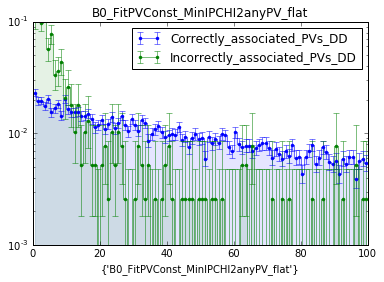

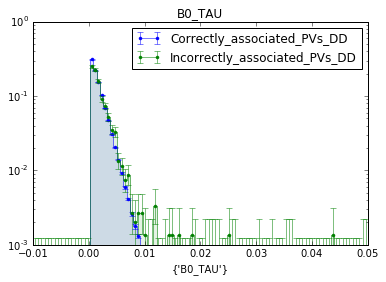

In [64]:
plot_vars = ['B0_FitPVConst_MinIPCHI2anyPV_flat',
             #'B0_FitPVConst_MinIPCHI2anyPV',
             'B0_TAU']

plot_names = ['B0_FitPVConst_MinIPCHI2anyPV_flat',
             #'B0_FitPVConst_MinIPCHI2anyPV',
             'B0_TAU']


plotter_dd = Plotter('/home/chasenberg/plots/wrong_pv/DD')
plotter_dd.create_plots(df_list_ll, plot_vars, None, plot_names, df_names_dd)
plotter_dd['B0_FitPVConst_MinIPCHI2anyPV_flat'].set_range(0,100)
plotter_dd['B0_FitPVConst_MinIPCHI2anyPV_flat'].set_log_y()
#plotter_dd['obsMassPsi2SKSConst'].set_log_y()
plotter_dd['B0_TAU'].set_range(-0.01,0.05)
plotter_dd['B0_TAU'].set_log_y()
plotter_dd.plot()

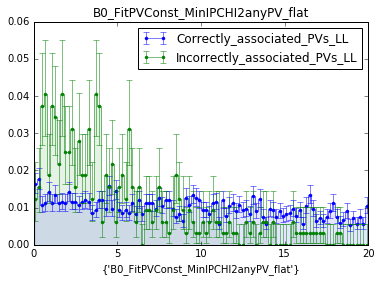

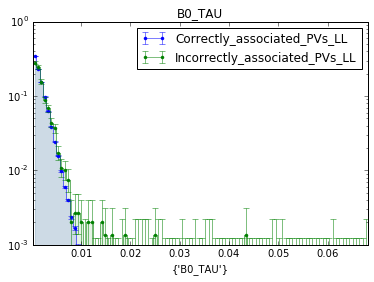

In [65]:
plotter_ll = Plotter('/home/chasenberg/plots/wrong_pv/LL')
plotter_ll.create_plots(df_list_ll, plot_vars, None, plot_names, df_names_ll)
plotter_ll['B0_FitPVConst_MinIPCHI2anyPV_flat'].set_range(0,20)
#plotter_ll['B0_FitPVConst_MinIPCHI2anyPV_flat'].set_log_y()
#plotter_ll['obsMassPsi2SKSConst'].set_log_y()
plotter_dd['B0_TAU'].set_range(-0.01,0.05)
plotter_ll['B0_TAU'].set_log_y()
plotter_ll.plot()

Check LL and DD together
-----------

In [66]:
df = rp.read_root(signal_dir, tree_name, columns=branch_names_mc, flatten=False)
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

In [67]:
df_correct_pv = df.query('abs(pv_z_pull)<20&idxPV==0')
df_incorrect_pv = df.query('abs(pv_z_pull)>20')
df_listing = [df_correct_pv,  df_incorrect_pv]
df_names = ['Correctly_associated_PVs', 'Incorrectly_associated_PVs']

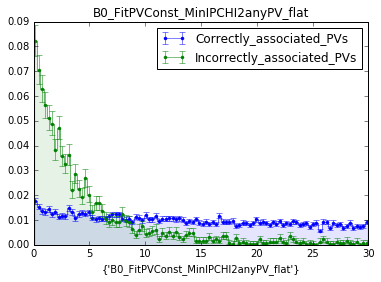

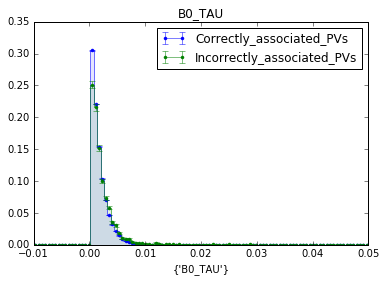

In [68]:
plot_vars = ['B0_FitPVConst_MinIPCHI2anyPV_flat',
             #'B0_FitPVConst_MinIPCHI2anyPV',
             'B0_TAU']

plot_names = ['B0_FitPVConst_MinIPCHI2anyPV_flat',
             #'B0_FitPVConst_MinIPCHI2anyPV',
             'B0_TAU']


plotter = Plotter('/home/chasenberg/plots/wrong_pv/')
plotter.create_plots(df_listing, plot_vars, None, plot_names,df_names)
plotter['B0_FitPVConst_MinIPCHI2anyPV_flat'].set_range(0,30)
plotter['B0_FitPVConst_MinIPCHI2anyPV_flat'].set_range(0,30)
#plotter_dd['obsMassPsi2SKSConst'].set_log_y()
plotter['B0_TAU'].set_range(-0.01,0.05)
#plotter['B0_TAU'].set_log_y()
plotter.plot()

### Check der alternativen Variablen

In [69]:
df_both = [df_correct_pv,  df_incorrect_pv]
df_names_both = ['Correctly_associated_PVs', 'Incorrectly_associated_PVs']